## Import modules

In [4]:
import os
import numpy as np
from scipy import misc
from scipy import signal
import sys
import random
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob
import time
from PIL import Image,ImageDraw,ImageOps
from scipy.signal import convolve2d
from scipy.ndimage.filters import maximum_filter
import imageio
import scipy.ndimage as ndimage
%matplotlib inline
import matplotlib.pyplot as plt
import getopt
import json
from resizeimage import resizeimage


## Get the data from sources

In [5]:
#Database location on Disk
gt_dir = r'C:\excellenteam\mobileye project\CityScapes\gtFine'
imgs_dir = r'C:\excellenteam\mobileye project\CityScapes\leftImg8bit'

# Import data
gt_train_path = os.path.join(gt_dir, 'train')
imgs_train_path = os.path.join(imgs_dir, 'train')
gt_val_path = os.path.join(gt_dir, 'val')
imgs_val_path = os.path.join(imgs_dir, 'val')
gt_test_path = os.path.join(gt_dir, 'test')
imgs_test_path = os.path.join(imgs_dir, 'test')
# Get training data filenames
def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    js=[]
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*color.png"))
        js += glob.glob(os.path.join(new_gt_path, "*polygons.json"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt , js

train_imgs, train_gt, train_js = get_files(imgs_train_path, gt_train_path)
val_imgs, val_gt, val_js= get_files(imgs_val_path, gt_val_path)
test_imgs, test_gt, test_js = get_files(imgs_test_path, gt_test_path)

## Plot a polygon

In [6]:
def plot_polygon(img,coord):
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #create lists of x and y values
    plt.figure()
    plt.plot(xs,ys) 
    plt.show() 

## Crop images

In [7]:
def crop_item(x,y,img_path,crop_size):
    pad_size_w=crop_size[1]//2
    pad_size_h=crop_size[0]//2
    image=plt.imread(img_path)
        
    image_padding= np.pad(image, ((pad_size_w,pad_size_w), (pad_size_h,pad_size_h),(0,0)),mode='symmetric')
    crop=image_padding[y:y+crop_size[0],x:x+crop_size[1]]
    crop_reflect=crop[:,::-1] #reflect image horizonal
    return crop,crop_reflect


## Create data function

In [8]:
def save_cropped_image(img,label,path_data,path_labels):
    #save cropped image
    img*=255
    np_cropped=np.asarray(img,dtype="uint8")
    np_labels=np.asarray([label],dtype="uint8")

    with open(path_data,"ab") as file_w:
        np_cropped.tofile(file_w)

    with open(path_labels,"ab") as file_w:
        np_labels.tofile(file_w)
        

In [9]:
def create_data(path_data,path_labels,list_js,list_imgs,crop_size):

    if os.path.isfile(path_data):
        os.remove(path_data)
    if os.path.isfile(path_labels):
        os.remove(path_labels)

    for j in range(len(list_imgs)):
                     
        with open(list_js[j]) as js:
            f=json.load(js)
        count_traffic_light=0
        count_other_obj=0

        if len([obj["label"] for obj in f["objects"] if obj['label']=="traffic light"])>0:

            for i,obj in enumerate(f.get("objects")):
                
                if count_traffic_light and count_other_obj:
                    break

                if count_traffic_light !=5 and obj.get("label")=="traffic light":
                    coord=obj["polygon"]
                    x,y=obj["polygon"][1]
                    crop_img,crop_reflect=crop_item(x,y,list_imgs[j],crop_size)
                    if crop_img.shape==crop_size:
                        count_traffic_light+=1
                        #save cropped image
                        save_cropped_image(crop_img,1,path_data,path_labels)
                            
                        #save cropped reflect image
                        save_cropped_image(crop_reflect,1,path_data,path_labels)



                if count_other_obj !=5: # is not a traffic light
                    coord=obj["polygon"]
                    x,y=obj["polygon"][1]
                    crop_img,crop_reflect=crop_item(x,y,list_imgs[j],crop_size)

                    if crop_img.shape==crop_size:
                        count_other_obj+=1
                        
                        #save cropped image
                        save_cropped_image(crop_img,0,path_data,path_labels)
                            
                        #save cropped reflect image
                        save_cropped_image(crop_reflect,0,path_data,path_labels)

                else: # if there is no traffic light
                    pass


## Create data for TRAIN

In [10]:
path_train_data=r'DATA_DIR/TRAIN/data.bin'
path_train_labels=r'DATA_DIR/TRAIN/labels.bin'

crop_size=(81,81,3)
# create_data(path_train_data,path_train_labels,train_js,train_imgs,crop_size)

## Create data for VAL

In [11]:
path_val_data=r'DATA_DIR/VAL/data.bin'
path_val_labels=r'DATA_DIR/VAL/labels.bin'

crop_size=(81,81,3)
# create_data(path_val_data,path_val_labels,val_js,val_imgs,crop_size)


## Show sample function

In [34]:
def show_sample(filename,idx,crop_size):
    newfp = np.memmap(filename, dtype='uint8',offset=idx*crop_size[0]*crop_size[1]*crop_size[2], mode='r', shape=crop_size)
    label_f_name=filename.replace("data","labels")
    count_labels=np.fromfile(label_f_name).shape
    labels = np.memmap(label_f_name,offset=idx, dtype='uint8', mode='r', shape=(1,))
    plt.figure()
    plt.title("True" if labels else "False")
    plt.imshow(newfp)

In [22]:
def show_sample_ax(filename,idx,crop_size):
    newfp = np.memmap(filename, dtype='uint8',offset=idx*crop_size[0]*crop_size[1]*crop_size[2], mode='r', shape=crop_size)
    print("image " + str(newfp.shape) + " " + str(newfp.dtype))
    label_f_name=filename.replace("data","labels")
    count_labels=num=np.fromfile(filename, dtype="uint8").shape[0]//(81*81*3)
    labels = np.memmap(label_f_name, dtype='uint8', mode='r', shape=count_labels)
    print("labels " + str(labels.shape) + " " + str(labels.dtype))
    text="Traffic light" if labels[idx] else "Not Traffic light"
    
    return newfp,text


## Show 2 samples for train

In [23]:
path_train_data=r'DATA_DIR/TRAIN/data.bin'
path_train_labels=r'DATA_DIR/TRAIN/labels.bin'

num=np.fromfile(path_train_data, dtype="uint8").shape[0]//(81*81*3)
print(f"train data has {num} samples")


train data has 19862 samples


## Show 2 samples for val

In [24]:
path_val_data=r'DATA_DIR/VAL/data.bin'
path_val_labels=r'DATA_DIR/VAL/labels.bin'

num=np.fromfile(path_val_data, dtype="uint8").shape[0]//(81*81*3)
print(f"val data has {num} samples")


val data has 3486 samples


## Sample 30 random cropped images

image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19862,) uint8
image (81, 81, 3) uint8
labels (19

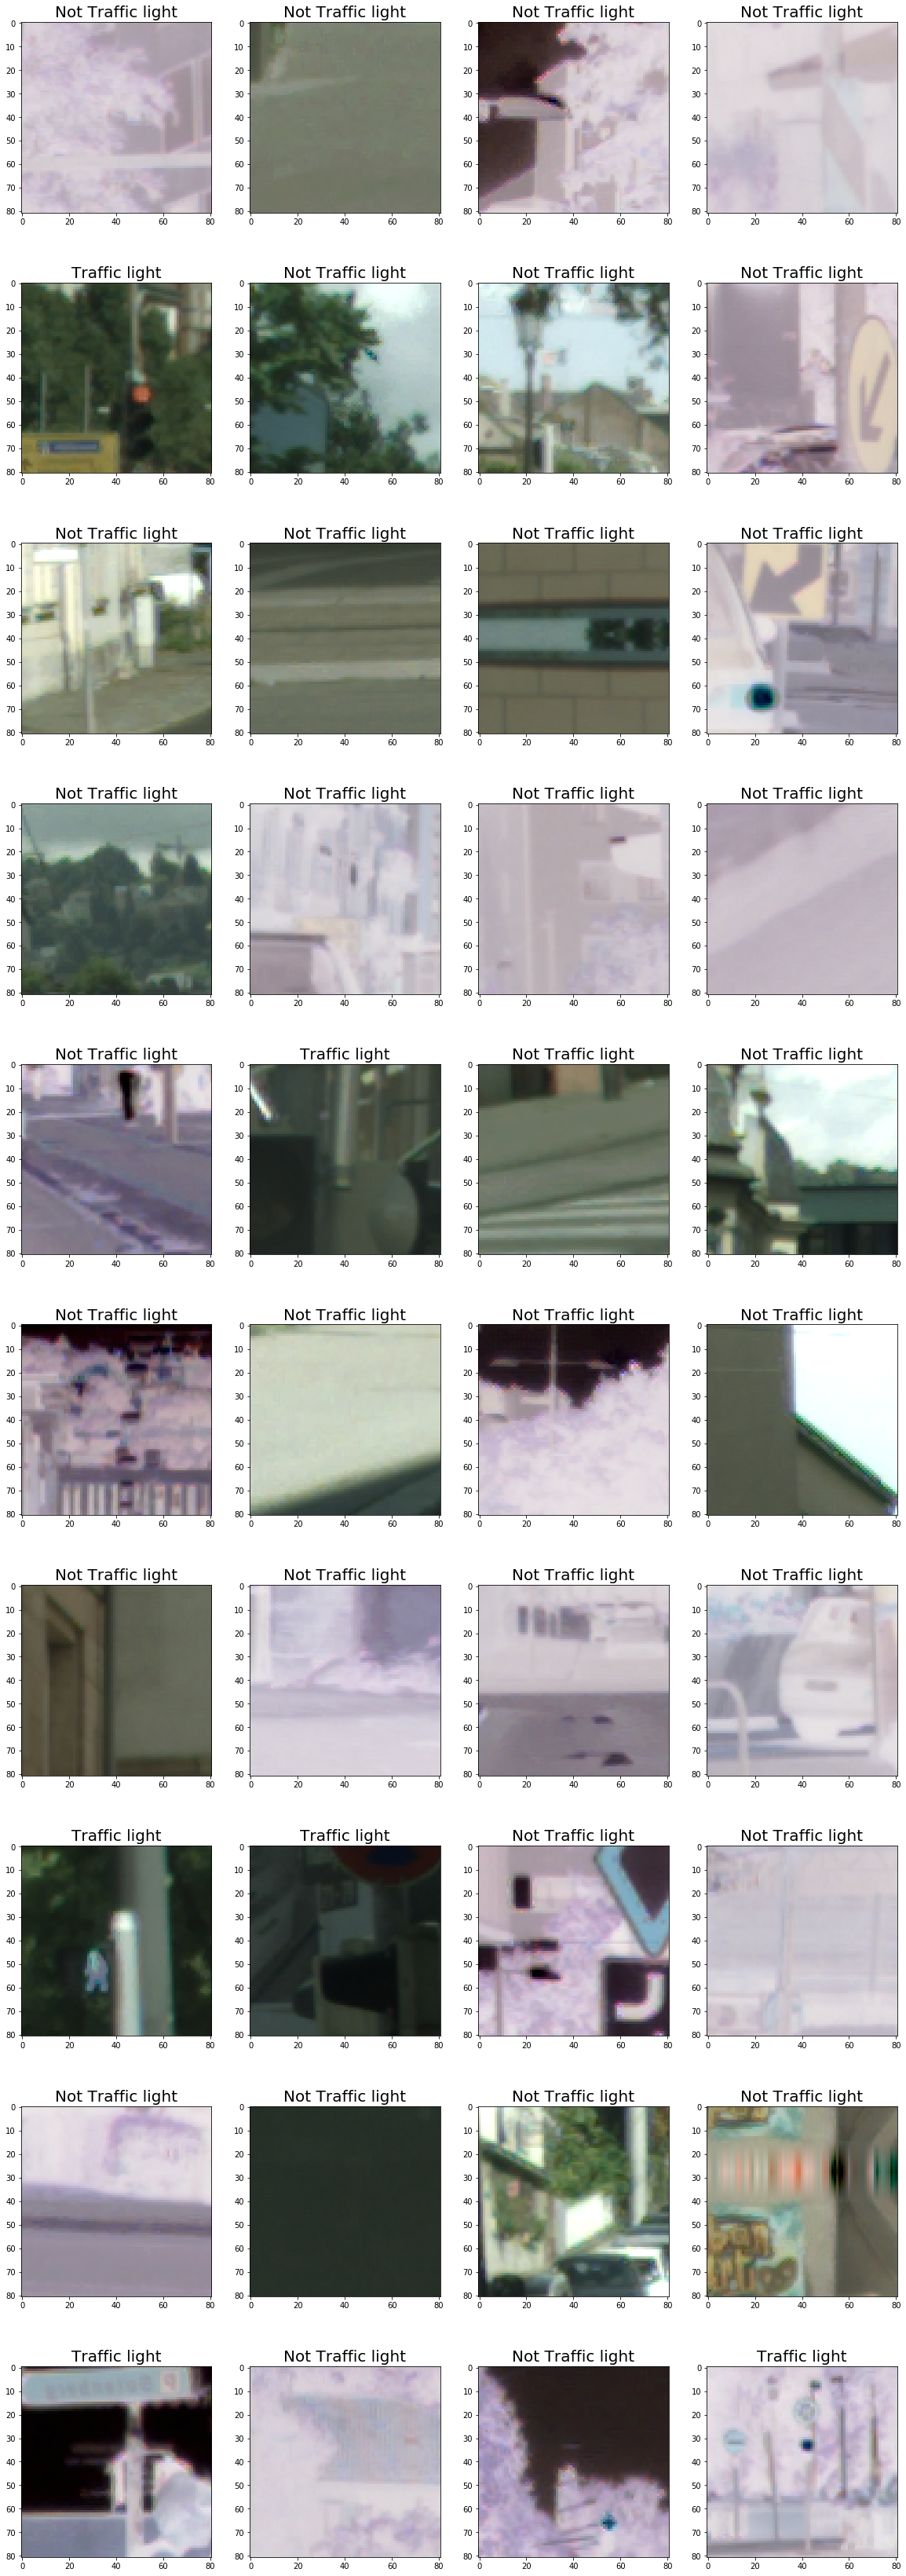

In [26]:
path_train_data=r'DATA_DIR/TRAIN/data.bin'
path_train_labels=r'DATA_DIR/TRAIN/labels.bin'

num=np.fromfile(path_train_labels, dtype="uint8").shape[0]

fig = plt.figure( figsize=(20,60))

for i,rand_id in enumerate(random.choices(range(15000, 19000), k=40)):
    newfp,text=show_sample_ax(path_train_data,rand_id,crop_size)
    a = fig.add_subplot(10,4,i+1);
    a.imshow(newfp);
    a.set_title(text,fontsize=20);
    
plt.show()